In [1]:

# === 0. IMPORTS ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, classification_report, confusion_matrix, brier_score_loss

)


from sklearn.linear_model import LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# === 1. CHARGEMENT DES DONNÉES ===

X = pd.read_csv("data/X_selections.csv")
y = pd.read_csv("data/y.csv").squeeze()
y.name = "target"

print(f"Shape X: {X.shape} | Shape y: {y.shape}")
print("Distribution de la cible (train/test avant split):\n",
      y.value_counts(normalize=True).round(3))

# Split stratifié train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

Shape X: (98053, 25) | Shape y: (98053,)
Distribution de la cible (train/test avant split):
 target
0    0.887
1    0.113
Name: proportion, dtype: float64


In [4]:
# === 2. MODELE LOGISTIQUE  ===

logit = LogisticRegression(
             
    solver="liblinear",
    class_weight="balanced",
    max_iter=2000,
    random_state=RANDOM_STATE
)

logit.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42,
                   solver='liblinear')

In [5]:
# === 4. ÉVALUATION SUR TEST ===

proba_test = logit.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, proba_test)
roc_auc = roc_auc_score(y_test, proba_test)
brier = brier_score_loss(y_test, proba_test)

print(f"\n=== Performances sur test ===")
print(f"PR-AUC : {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Brier  : {brier:.5f}")


=== Performances sur test ===
PR-AUC : 0.1927
ROC-AUC: 0.6328
Brier  : 0.23253


In [6]:
# === 5. métrique ===

prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = int(np.nanargmax(f1))
best_thr = thr[min(max(best_idx-1, 0), len(thr)-1)] if len(thr) > 0 else 0.5

print(f"\nSeuil optimal (F1 max): {best_thr:.4f}")

y_pred = (proba_test >= best_thr).astype(int)

print("\n=== Rapport de classification (test) ===")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion (test):\n", cm)


Seuil optimal (F1 max): 0.4894

=== Rapport de classification (test) ===
              precision    recall  f1-score   support

           0      0.917     0.660     0.767     17398
           1      0.166     0.531     0.253      2213

    accuracy                          0.645     19611
   macro avg      0.541     0.595     0.510     19611
weighted avg      0.832     0.645     0.709     19611

Matrice de confusion (test):
 [[11474  5924]
 [ 1037  1176]]


In [7]:
# === 6. INTERPRÉTATION DES COEFFICIENTS ===

coef = pd.Series(logit.coef_.ravel(), index=X_train.columns, name="beta")
odds = np.exp(coef).rename("odds_ratio")

interpret_table = pd.concat([coef, odds], axis=1)
interpret_table["abs_beta"] = interpret_table["beta"].abs()
interpret_table = interpret_table.sort_values("abs_beta", ascending=False)

print("\nTop 20 variables par |β| :")
print(interpret_table[["beta", "odds_ratio"]].head(20))

# Sauvegarde
Path("outputs").mkdir(exist_ok=True)
interpret_table.to_csv("outputs/logreg_interpretation.csv")
pd.DataFrame({"y_true": y_test.values,
              "proba": proba_test,
              "y_pred": y_pred}).to_csv(
    "outputs/test_predictions.csv", index=False
)


Top 20 variables par |β| :
                              beta  odds_ratio
number_inpatient          0.362635    1.437111
race_Asian                0.164972    1.179360
discharge_disposition_id  0.135861    1.145523
nateglinide              -0.109568    0.896222
number_diagnoses          0.097107    1.101978
metformin                -0.089200    0.914662
age_(50-60).1            -0.083484    0.919906
age_(50-60)              -0.083484    0.919906
number_emergency          0.078953    1.082154
time_in_hospital          0.074520    1.077367
num_procedures           -0.072233    0.930314
num_medications           0.054837    1.056368
age_(70-80)               0.039197    1.039975
age_(20-30)              -0.034419    0.966166
race_Caucasian            0.032759    1.033302
age_(30-40)              -0.027602    0.972776
diag_1                   -0.021084    0.979136
admission_source_id      -0.017129    0.983017
gender_Male               0.010995    1.011056
num_lab_procedures        0.0105

<Figure size 600x400 with 0 Axes>

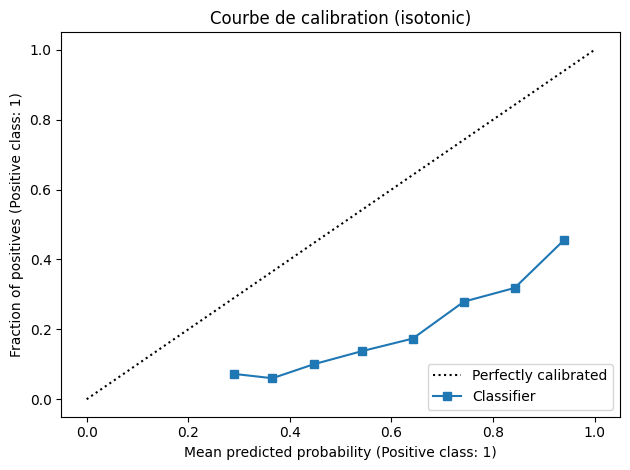

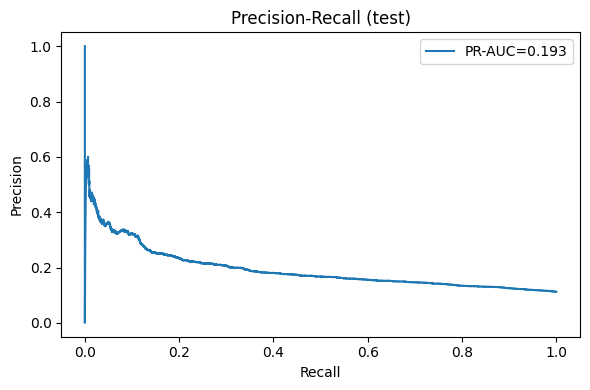

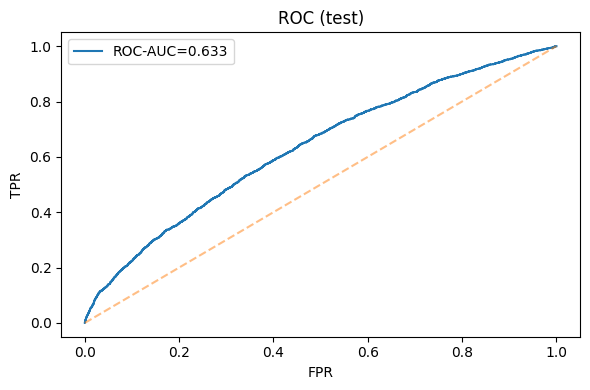

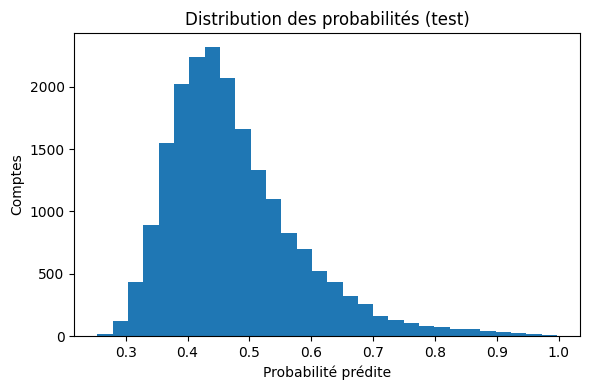

In [8]:
# === 7. VISUALISATIONS ===

# Calibration
plt.figure(figsize=(6,4))
CalibrationDisplay.from_predictions(y_test, proba_test, n_bins=10)
plt.title("Courbe de calibration (isotonic)")
plt.tight_layout()
plt.show()

# PR Curve
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR-AUC={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (test)")
plt.legend()
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (test)")
plt.legend()
plt.tight_layout()
plt.show()

# Histogramme
plt.figure(figsize=(6,4))
plt.hist(proba_test, bins=30)
plt.xlabel("Probabilité prédite")
plt.ylabel("Comptes")
plt.title("Distribution des probabilités (test)")
plt.tight_layout()
plt.show()


In [14]:
# === 2bis. MODELE LOGISTIQUE AVEC SMOTE ===
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote_logit = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="liblinear",
        class_weight="balanced",   # tu peux mettre None si tu veux éviter double correction
        max_iter=2000,
        random_state=RANDOM_STATE
    ))
])

smote_logit.fit(X_train, y_train)

# Prédictions SMOTE
proba_test_sm = smote_logit.predict_proba(X_test)[:, 1]

# Scores SMOTE
pr_auc_sm = average_precision_score(y_test, proba_test_sm)
roc_auc_sm = roc_auc_score(y_test, proba_test_sm)
brier_sm = brier_score_loss(y_test, proba_test_sm)

print("\n=== Performances SMOTE (test) ===")
print(f"PR-AUC : {pr_auc_sm:.4f}")
print(f"ROC-AUC: {roc_auc_sm:.4f}")
print(f"Brier  : {brier_sm:.5f}")

# Seuil optimal SMOTE
prec_sm, rec_sm, thr_sm = precision_recall_curve(y_test, proba_test_sm)
f1_sm = 2 * prec_sm * rec_sm / (prec_sm + rec_sm + 1e-12)
best_idx_sm = int(np.nanargmax(f1_sm))
best_thr_sm = thr_sm[min(max(best_idx_sm-1, 0), len(thr_sm)-1)] if len(thr_sm) > 0 else 0.5

print(f"\nSeuil optimal SMOTE (F1 max): {best_thr_sm:.4f}")

y_pred_sm = (proba_test_sm >= best_thr_sm).astype(int)

print("\n=== Rapport de classification SMOTE (test) ===")
print(classification_report(y_test, y_pred_sm, digits=3))



=== Performances SMOTE (test) ===
PR-AUC : 0.1805
ROC-AUC: 0.6045
Brier  : 0.23310

Seuil optimal SMOTE (F1 max): 0.5589

=== Rapport de classification SMOTE (test) ===
              precision    recall  f1-score   support

           0      0.908     0.775     0.836     17398
           1      0.177     0.380     0.242      2213

    accuracy                          0.731     19611
   macro avg      0.542     0.578     0.539     19611
weighted avg      0.825     0.731     0.769     19611



In [13]:
print("\n=== COMPARAISON LOGIT vs LOGIT+SMOTE ===")

df_comp = pd.DataFrame({
    "Metric": ["ROC-AUC", "PR-AUC", "Brier"],
    "Logit": [roc_auc, pr_auc, brier],
    "SMOTE+Logit": [roc_auc_sm, pr_auc_sm, brier_sm]
})

print(df_comp)



=== COMPARAISON LOGIT vs LOGIT+SMOTE ===
    Metric     Logit  SMOTE+Logit
0  ROC-AUC  0.632834     0.604522
1   PR-AUC  0.192747     0.180514
2    Brier  0.232530     0.233096
